In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from utils import scatter_plot

%load_ext autoreload
%autoreload 2

In [2]:
ifmha = pd.read_csv('./dataset/IFMHA.csv', converters={'site_no': str}, low_memory=False)
ifmha.shape

(2802532, 47)

In [3]:
# Remove Zero/Missing Values
candidate_columns=['site_no', 'site_tp_cd', 'chan_discharge', 'chan_area', 'chan_width', 'SLOPE']

ifmha_subset = ifmha[(ifmha[candidate_columns] != 0).all(axis=1)]
ifmha_subset = ifmha_subset.dropna(axis=0, how='any', subset=candidate_columns)
print(f"dataset size: {ifmha_subset.shape}")

dataset size: (2248655, 47)


In [4]:
# Exclude USGS sites with negative discharge observations
ifmha_subset = ifmha_subset[ifmha_subset.groupby('site_no')['chan_discharge'].transform(lambda x: (x<0).sum()) == 0]
ifmha_subset.shape

(2107954, 47)

In [5]:
# Keep only sites categorized as channels or streams
ifmha_subset = ifmha_subset[ifmha_subset['site_tp_cd'].isin(['ST'])]
print(ifmha_subset.shape)

(2093881, 47)


In [6]:
# Mean depth estimation
ifmha_subset['chan_mean_depth'] = ifmha_subset['chan_area']/ifmha_subset['chan_width']

# Maximum depth estimation
ifmha_subset['chan_max_depth'] = 1.47910570 * ifmha_subset['chan_mean_depth'] - 0.02600691

In [7]:
# Sanity check for having physically meaningful channel characteristics
ifmha_subset = ifmha_subset[(ifmha_subset[['chan_area', 'chan_mean_depth', 'chan_max_depth']] > 0).all(axis=1)]
print(ifmha_subset.shape)

(2093328, 49)


### Statistics of IFMHA 

In [8]:
ifmha_subset['site_no'].value_counts().describe()

count    8431.000000
mean      248.289408
std       268.599205
min         1.000000
25%        62.000000
50%       194.000000
75%       340.000000
max      6580.000000
Name: count, dtype: float64

In [9]:
ifmha_site_list = ifmha_subset['site_no'].value_counts()
ifmha_subset_stat = ifmha_subset[ifmha_subset["site_no"].isin(ifmha_site_list.index[ifmha_site_list>=50].to_list())]

print("site locations with minimum of 50 observations: ")
print(f'Number of observations: {ifmha_subset_stat.shape}')
print('Number of sites:')
ifmha_subset_stat['site_no'].value_counts().describe()

site locations with minimum of 50 observations: 
Number of observations: (2064782, 49)
Number of sites:


count    6498.000000
mean      317.756540
std       269.268215
min        50.000000
25%       154.000000
50%       258.000000
75%       387.000000
max      6580.000000
Name: count, dtype: float64

### Stage-Discharge scatter plot for finding banckfull characteristics

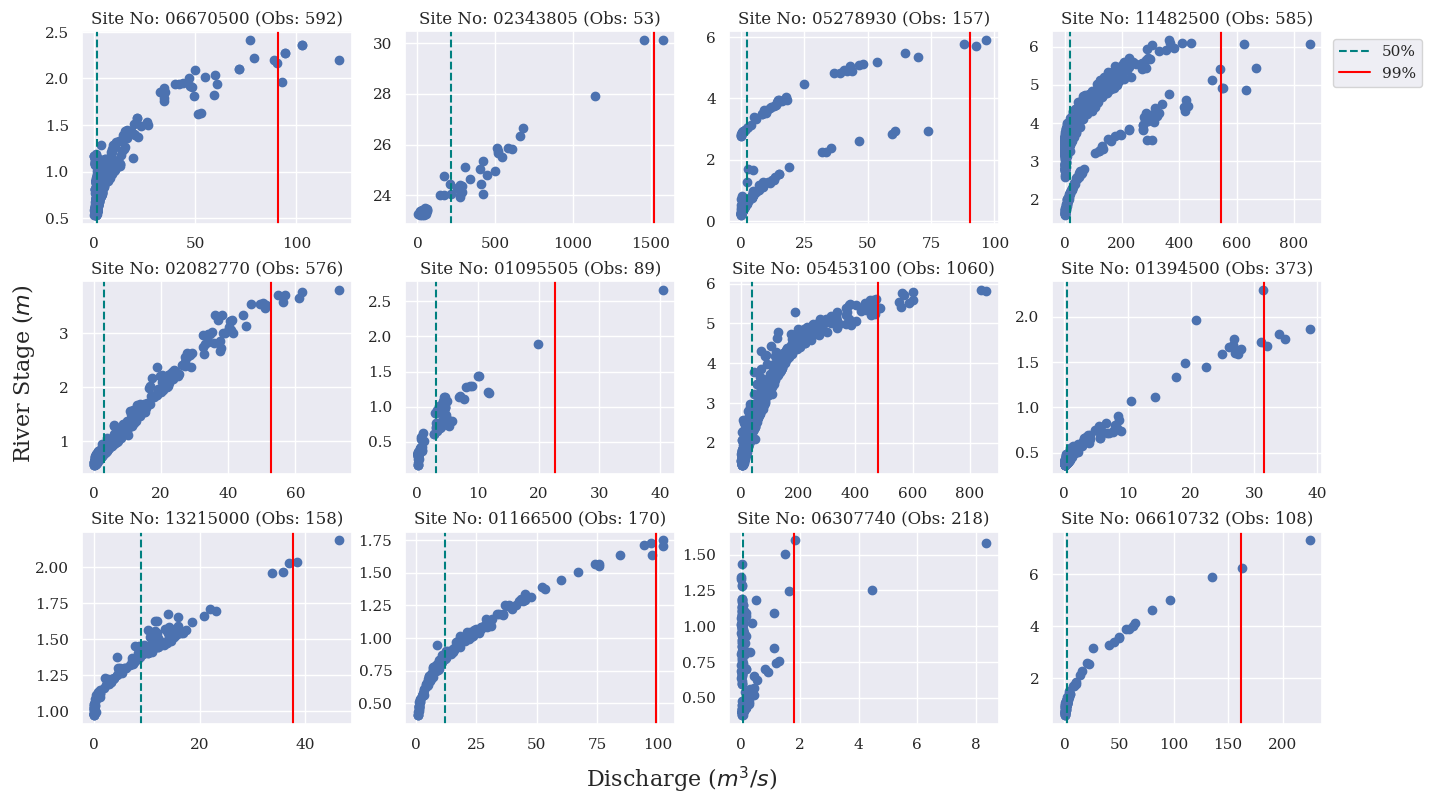

In [40]:
grouped_ifmha = ifmha_subset_stat.dropna(axis=0, how='any', subset=['gage_height_va']).reset_index(drop=True).groupby('site_no')

# Getting unique values from the grouped DataFrame
site_no = list(grouped_ifmha.groups.keys())

# Create a random number generator with seed 0
rng = np.random.default_rng(0)
# Generate 18 random number
random_sites = rng.choice(len(site_no), 18, replace=False).tolist()

fig, axes = plt.subplots(nrows=3, ncols=4 , figsize=(16, 9), constrained_layout=False)

fig.text(0.5, 0.04, r'Discharge ($m^3/s$)', ha='center')
fig.text(0.08, 0.5, r'River Stage ($m$)', va='center', rotation='vertical')

for idx, sn in enumerate(random_sites[:12]):
    i, j = divmod(idx, 4)

    df = grouped_ifmha.get_group(site_no[sn])
    q = df["discharge_va"] * 0.028316832 # cfs to m3/s
    s = df["gage_height_va"] * 0.3048    # ft to m
    idx2 = (s > s.quantile(0.01)) & (s < s.quantile(0.99))
    q = q[idx2]
    s = s[idx2]

    axes[i, j].scatter(q, s)
    axes[i, j].axvline(x=q.median() , color='teal', linestyle='--', label='50%')
    axes[i, j].axvline(x=q.quantile(0.99) , color='red', linestyle='-', label='99%')
    axes[i, j].set_title(f"Site No: {site_no[sn]} (Obs: {len(df)})")

plt.legend(bbox_to_anchor=(1.4, 3.6))
plt.subplots_adjust(hspace=0.3) # (left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

f = 'png'
plt.savefig(f'./discharge-stage-scatter.{f}', format=f'{f}', bbox_inches='tight', pad_inches=0.1)
plt.show()

Following code block finds the record (in the DataFrame) for in each USGS site station that its discharge is closest value to the median value 

In [11]:
# Function to find closest value to target within a group
def find_closest_value(group):
    median_val = group['discharge_va'].median()
    median_idx = (group['discharge_va'] - median_val).abs().argsort().values[0]
    closest_rec = group.iloc[median_idx]
    return closest_rec

candidate_columns = ['site_no', 'discharge_va', 'gage_height_va','dec_lat_va', 'dec_long_va', 'chan_mean_depth', 'chan_max_depth']

# Finding closest values to the medians within each group
closest_values = grouped_ifmha[candidate_columns].apply(find_closest_value)

closest_values.reset_index(drop=True, inplace=True)